In [1]:
import pickle
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ximc import XimcRedmine

user_name = ""
password = ""

try:
    ximc_user = XimcRedmine(user_name, password)
    ximc_user.auth()
except Exception:
    print("User authorization failed")
    sys.exit(0)

# Задаем параметры для первого запроса (фильтры задаются аналогично веб-интерфейсу ximc)
ximc_user.add_filter("Проект", "соответствует", "EP-software")
ximc_user.add_filter("Статус", "соответствует", "Closed")
ximc_user.add_filter("Трекер", "не соответствует", "Bug")
ximc_user.add_filter("Приоритет", "соответствует", "Normal")
ximc_user.add_filter("Автор", "не соответствует", "dasha")
ximc_user.add_filter("Назначена", "все")
ximc_user.add_filter("Версия", "соответствует", "Развитие-2018")
ximc_user.add_filter("Тема", "содержит", "к нашим")
ximc_user.add_filter("Описание", "начинается с", "Привести")
ximc_user.add_filter("Готовность", ">=", 50)
ximc_user.add_filter("Частная", "соответствует", "нет")
ximc_user.add_filter("Файл", "отсутствует")
ximc_user.add_filter("Кем изменено", "соответствует", "mikheev")
ximc_user.add_filter("Последний изменивший", "соответствует", "VladBelov")
ximc_user.add_filter("Задача", ">=", 20033)
# Запрашиваем необходимые итоговые параметры
totals = ximc_user.get_totals("Оценка временных затрат", "Трудозатраты", "Payment cash", "Payment cashless", "Rate")
# В итоге получаем словарь в виде: {"название параметра": значение}
print("Project: EP-software")
totals_options = "Оценка временных затрат", "Трудозатраты", "Payment cash", "Payment cashless", "Rate"
table = [(option, totals[option]) for option in totals_options]
pd.set_option('display.max_columns', None)
df = pd.DataFrame(table, columns=("Параметр", "Значение"))
print(df)

# Задаем параметры для следующего запроса. Но сначала нужно очистить ранее заданные фильтры
ximc_user.clear_filters()
# Задаем фильтры аналогично веб-интерфейсу ximc
ximc_user.add_filter("Project", "is", "Payments")
ximc_user.add_filter("Status", "closed")
ximc_user.add_filter("Created", "between", "2021-09-09", "2021-11-11")
# Запрашиваем необходимые итоговые параметры
totals = ximc_user.get_totals("Estimated time", "Spent time", "Payment cash", "Payment cashless", "Rate", "Payment tail")
# В итоге получаем словарь в виде: {"название параметра": значение}
print("\nProject: Payments")
for option_name, value in totals.items():
    print(f"{option_name}: {value}")

# Задаем параметры для следующего запроса. Но сначала нужно очистить ранее заданные фильтры
ximc_user.clear_filters()
ximc_user.add_filter("Status", "is", "Closed")
ximc_user.add_filter("Tracker", "is not", "Bug")
ximc_user.add_filter("Priority", "is", "Normal")
ximc_user.add_filter("Author", "is", "dasha")
ximc_user.add_filter("Assignee", "is", "vladimirov_iy")
ximc_user.add_filter("% Done", ">=", 50)
# Запрашиваем необходимые итоговые параметры
totals = ximc_user.get_totals("Estimated time", "Spent time", "Payment cash", "Payment cashless", "Rate")
# В итоге получаем словарь в виде: {"название параметра": значение}
print("\nAll projects")
for option_name, value in totals.items():
    print(f"{option_name}: {value}")

Project: EP-software
                  Параметр  Значение
0  Оценка временных затрат      3.00
1             Трудозатраты     16.35
2             Payment cash      0.00
3         Payment cashless      0.00
4                     Rate      0.00

Project: Payments
Estimated time: 0.0
Spent time: 0.0
Payment cash: 69820.0
Payment cashless: 117322.0
Rate: 1200.0
Payment tail: 8081.0

All projects
Estimated time: 0.0
Spent time: 0.0
Payment cash: 6400.0
Payment cashless: 0.0
Rate: 500.0


In [2]:
# Имена проектов, для которых будем сравнивать данные
project_names = [project_name for _, project_name in ximc_user.get_projects()]
# Перебираем проекты из списка и получаем для них данные с применением фильтров
START_TIME = datetime.strptime("2020-01-01", "%Y-%m-%d")
END_TIME = datetime.strptime("2021-12-31", "%Y-%m-%d")
result = {}
for project_name in project_names:
    result_for_project = []
    print(f"\nПроект: {project_name}")
    start_time = START_TIME
    while start_time < END_TIME:    
        start_time_in_str = start_time.strftime("%Y-%m-%d")
        end_time = start_time + timedelta(days=30)
        end_time_in_str = end_time.strftime("%Y-%m-%d")
        # Задаем фильтры аналогично веб-интерфейсу ximc
        ximc_user.clear_filters()
        ximc_user.add_filter("Project", "is", project_name)
        ximc_user.add_filter("Status", "is", "Closed")
        ximc_user.add_filter("Tracker", "is not", "Bug")
        ximc_user.add_filter("Created", ">=", start_time_in_str)
        ximc_user.add_filter("Created", "<=", end_time_in_str)
        # Запрашиваем необходимые итоговые параметры
        totals = ximc_user.get_totals("Оценка временных затрат", "Трудозатраты")
        if totals["Оценка временных затрат"] is None:
            estimated_time = 0
        else:
            estimated_time = totals["Оценка временных затрат"]
        if totals["Трудозатраты"] is None:
            spent_time = 0
        else:
            spent_time = totals["Трудозатраты"]
        result_for_project_in_given_period = {"start_time": start_time, "end_time": end_time,
                                              "estimated_time": estimated_time, "spent_time": spent_time}
        result_for_project.append(result_for_project_in_given_period)
        start_time = end_time
        print(f"в период с {start_time_in_str} по {end_time_in_str}: оценка временных затрат = {estimated_time} ч, "
              f"трудозатраты = {spent_time} ч")
    result[project_name] = result_for_project

# Сохраняем результат в файл
FILE_FOR_RESULT = "result.pickle"
with open(FILE_FOR_RESULT, "wb") as file:
    pickle.dump(result, file)


Проект: Shared-service
в период с 2020-01-01 по 2020-01-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-01-31 по 2020-03-01: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-01 по 2020-03-31: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-03-31 по 2020-04-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-04-30 по 2020-05-30: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-05-30 по 2020-06-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-06-29 по 2020-07-29: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-07-29 по 2020-08-28: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-08-28 по 2020-09-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-09-27 по 2020-10-27: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-10-27 по 2020-11-26: оценка временных затрат = 0 ч, трудозатраты = 0 ч
в период с 2020-11-

In [11]:
# Читаем результат из файла
with open(FILE_FOR_RESULT, "rb") as file:
    result = pickle.load(file)

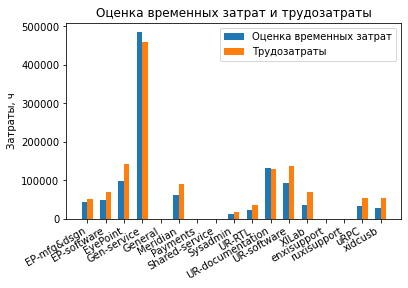

In [14]:
# Построение графика с полными значениями трудозатрат для проектов
# Сначала получаем готовим данные
project_names = sorted(list(result.keys()))
estimated_times = []
spent_times = []
for project_name in project_names:
    estimated_time = 0
    spent_time = 0
    for item in result[project_name]:
        estimated_time += item["estimated_time"]
        spent_time += item["spent_time"]
    estimated_times.append(estimated_time)
    spent_times.append(spent_time)
# Потом рисуем
fig, ax = plt.subplots()
x = np.arange(len(project_names))
width = 0.3
ax.bar(x - width / 2, estimated_times, width, label="Оценка временных затрат")
ax.bar(x + width / 2, spent_times, width, label="Трудозатраты")
ax.set_xticks(x)
ax.set_xticklabels(project_names)
ax.set_title("Оценка временных затрат и трудозатраты")
ax.set_ylabel("Затраты, ч")
ax.legend()
fig.autofmt_xdate()
plt.show()

In [15]:
# Создание таблицы
table = [(project_name, estimated_times[i], spent_times[i]) for i, project_name in enumerate(project_names)]
pd.DataFrame(table, columns=("Проект", "Оценка временных затрат, ч", "Трудозатраты, ч"))

,Проект,"Оценка временных затрат, ч","Трудозатраты, ч"
0,EP-mfg&dsgn,43499.00,50250.06
1,EP-software,48245.25,69910.53
2,EyePoint,98032.50,143361.50
3,Gen-service,485259.25,459828.93
4,General,0.00,0.00
5,Meridian,60693.00,88866.05
6,Payments,0.00,0.00
7,Shared-service,335.00,314.35
8,Sysadmin,11481.00,16163.11
9,UR-RTL,22205.00,34836.12


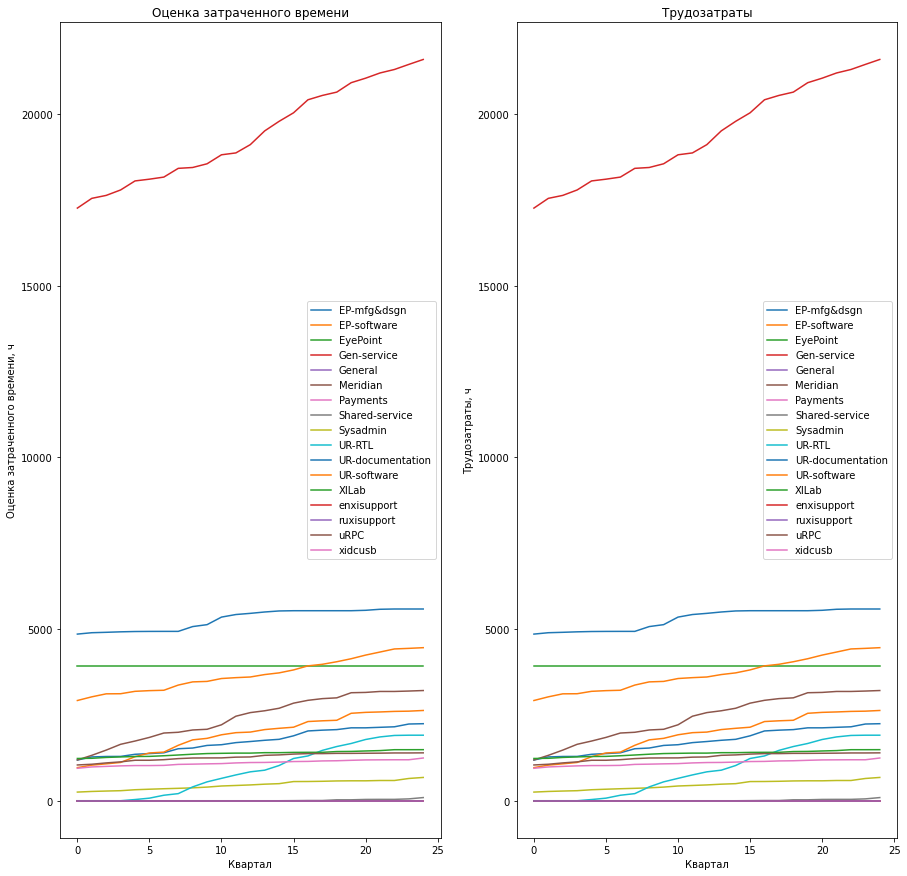

In [21]:
# Постоение графика с линиями
# Сначала готовим данные
project_names = sorted(list(result.keys()))
estimated_times = []
spent_times = []
for project_name in project_names:
    estimated_times.append([item["estimated_time"] for item in result[project_name]])
    spent_times.append([item["estimated_time"] for item in result[project_name]])
# Потом рисуем
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
for index, project in enumerate(project_names):
    ax1.plot(estimated_times[index], label=project)
    ax2.plot(spent_times[index], label=project)
ax1.set_title("Оценка затраченного времени")
ax1.set_xlabel("Квартал")
ax1.set_ylabel("Оценка затраченного времени, ч")
ax1.legend()
ax2.set_title("Трудозатраты")
ax2.set_xlabel("Квартал")
ax2.set_ylabel("Трудозатраты, ч")
ax2.legend()

In [22]:
# Получаем ID и названия всех проектов в ximc
projects = ximc_user.get_projects()
pd.DataFrame(projects, columns=("ID", "Проект"))

,ID,Проект
0,202,Shared-service
1,66,EyePoint
2,86,EP-mfg&dsgn
3,85,EP-software
4,71,General
5,72,Gen-service
6,113,Sysadmin
7,109,Meridian
8,69,Payments
9,80,UR-documentation
